# MBA em Ciência de Dados
# Técnicas Avançadas de Captura e Tratamento de Dados


### <span style="color:darkred">Tratamento e limpeza de bases de dados</span>


### <span style="color:darkred">Tratamento de desbalanceamento: subamostragem e aumentação de dados</span>

Material Produzido por Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn import over_sampling
from imblearn import under_sampling
from imblearn import combine

ImportError: cannot import name 'DistanceMetric' from 'sklearn.metrics' (/Users/jp.ducatti/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/__init__.py)

# Dados Desbalanceados

Vamos estudar o problema de dados desbalanceados utilizando o conjunto de dados de natalidade em uma maternidade.

In [23]:
data = pd.read_csv("./dados/TACTD-01-Desbalanceamento.csv")
data.head()

,Sex,Gestational age,Month,Year,Weight,Hospital,Date
0,F,38,12,2016,3740,St Mary,201612
1,M,39,12,2016,4130,St Mary,201612
2,M,42,12,2016,4250,St Mary,201612
3,F,39,12,2016,3990,St Mary,201612
4,F,38,12,2016,3760,St Mary,201612


In [24]:
data['Sex'].value_counts()

F    58
M    18
Name: Sex, dtype: int64

In [25]:
cont = data['Sex'].value_counts()

# relacao entre classe majoritaria e minoritaria
ratio = np.round((cont[1]/cont[0])*10,1)

# percentual
perce = (np.min(cont)/data.shape[0])*100

In [26]:
print('Problema com relaçao 1:'+str(ratio))
print('Classe minoritária com frequência: %.1f%%' % (perce)) 

Problema com relaçao 1:3.1
Classe minoritária com frequência: 23.7%


Nesse caso temos um desbalanceamento de aproximadamente 1:3

Ao inferir modelos temos que tratar a amostra relativa ao Sexo Feminino e ao Sexo Masculino de forma a controlar por essa diferença.

Em alguns métodos de aprendizado, por exemplo, a quantidade de dados é levada em consideração e pode trazer um peso maior para a categoria chamada de *majoritária*, nesse caso o sexo Feminino.


O efeito de desbalanceamento pode causar o deslocamento de uma superfície de decisão aprendida, favorecendo a classe majoritária

<img src="imagens/desb_1_deci.png" width=280>

---



# Métodos de tratamento de desbalanceamento

1. **Subamostragem**: remove exemplos da classe majoritária
2. **Aumentação de dados/sobreamostragem**: cria *novos* exemplos sintéticos/artificiais para a classe minoritária

### Subamostragem aleatória

<img src="imagens/desb_2_unders.png" width=400>


### SMOTE

Método de sobreamostragem *Synthetic Minority Oversampling Technique*

<img src="imagens/desb_3_SMOTE.png" width=600>

### TomekLinks

Método de remoção de exemplos com base no vizinho mais próximo

<img src="imagens/desb_4_tomek.png" width=600>

### Edited Nearest Neighbors (ENN)

Utiliza $k$ vizinhos mais próximos ao invés de um único como no Tomek

---

Vamos utilizar uma base de dados desbalanceada para mostrar alguns métodos

In [27]:
# https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent
data = pd.read_csv("./dados/houses_to_rent_mba_nomissing2.csv")

# tratamento de dados
data_nred = data.drop_duplicates(keep='first').copy()
data_nred.loc[data_nred['floor']=='-','floor'] = '0'
data_nred.loc[:,'floor'] = pd.to_numeric(data_nred['floor'], downcast='integer', errors='coerce')
data_nred.loc[:,'tax'] = pd.to_numeric(data_nred['tax'], downcast='float', errors='coerce')
data_nred = data_nred.dropna()

In [28]:
# remoção de outliers
def remove_outliers(df, attributes, factor=2):
    for var in attributes:
        # verifica se variável é numerica
        if np.issubdtype(df[var].dtype, np.number):
            Q1 = df[var].quantile(0.25)
            Q2 = df[var].quantile(0.25)
            Q3 = df[var].quantile(0.75)
            IQR = Q3 - Q1
        
        # apenas inliers segundo IQR
        df = df.loc[(df[var] >= Q1-(IQR*factor)) & (df[var] <= Q3+(IQR*factor)), :]
    return df

attributes = ['tax','insurance', 'hoa', 'rent']
data_out = remove_outliers(data_nred, attributes)

print("Antes: %d, Depois tratamento: %d" % (data_nred.shape[0], data_out.shape[0]))

Antes: 10695, Depois tratamento: 8811


Vamos separar essa base de dados em conjuntos de treinamento (X) e teste (Z)

In [29]:
frac_trein = 0.8
dtrain = data.sample(frac=frac_trein, random_state=1)
dtest = data.drop(dtrain.index)

Agora vamos treinar:
1. classificador para predizer a **cidade** com base no imposto, valor do condomínio e valor do seguro, e valor do condomínio

In [30]:
# Treinando classificador
X = dtrain[['tax','insurance', 'hoa']]
Y = dtrain['city']

ZX = dtest[['tax','insurance', 'hoa']]
ZY = dtest['city']

clf = SVC(gamma='auto')
clf.fit(X,Y)
ZY_ = clf.predict(ZX)

In [31]:
acc_base = metrics.accuracy_score(ZY, ZY_)
accb_base = metrics.balanced_accuracy_score(ZY, ZY_)
print("Acurácia: %0.2f" % (acc_base*100))
print("Acurácia balanceada: %0.2f" % (accb_base*100))

Acurácia: 61.79
Acurácia balanceada: 28.88


<AxesSubplot:>

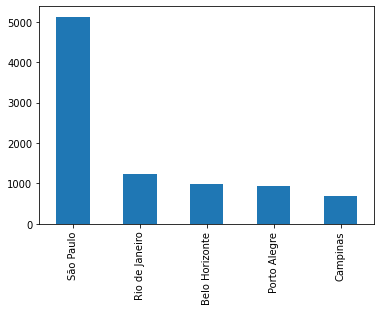

In [35]:
dtrain['city'].value_counts().plot.bar()

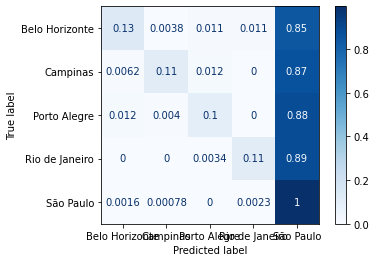

In [36]:
disp = ConfusionMatrixDisplay.from_estimator(clf, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

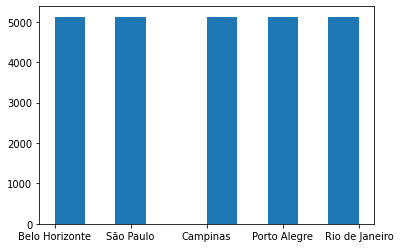

In [37]:
oversamp = over_sampling.SMOTE() # sampling_strategy pode ser usado para casos binários
Xo, Yo = oversamp.fit_resample(X, Y)
h = plt.hist(Yo)

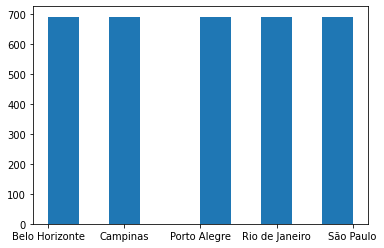

In [38]:
undersamp = under_sampling.RandomUnderSampler()
Xu, Yu = undersamp.fit_resample(X, Y)

h = plt.hist(Yu)

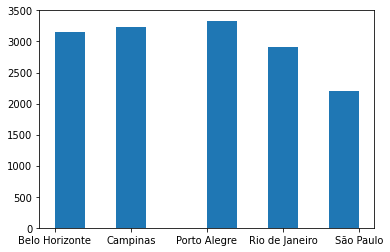

In [39]:
overunder = combine.SMOTEENN(sampling_strategy='all')
Xc, Yc = overunder.fit_resample(X, Y)

h = plt.hist(Yc)

In [16]:
clf_ov = SVC(gamma='auto')
clf_ov.fit(Xo,Yo)
ZYov_ = clf_ov.predict(ZX)

clf_un = SVC(gamma='auto')
clf_un.fit(Xu,Yu)
ZYun_ = clf_un.predict(ZX)

clf_co = SVC(gamma='auto')
clf_co.fit(Xc,Yc)
ZYco_ = clf_co.predict(ZX)

In [40]:
accb_ov = metrics.balanced_accuracy_score(ZY, ZYov_)
accb_un = metrics.balanced_accuracy_score(ZY, ZYun_)
accb_co = metrics.balanced_accuracy_score(ZY, ZYco_)
print("Acurácia balanceada base: %0.3f" % (accb_base))
print("- oversampling (SMOTE): %0.3f" % (accb_ov))
print("- undersampling: %0.3f" % (accb_un))
print("- oversampling + undersampling (SMOTEENN): %0.3f" % (accb_co))

Acurácia balanceada base: 0.289
- oversampling (SMOTE): 0.355
- undersampling: 0.353
- oversampling + undersampling (SMOTEENN): 0.345


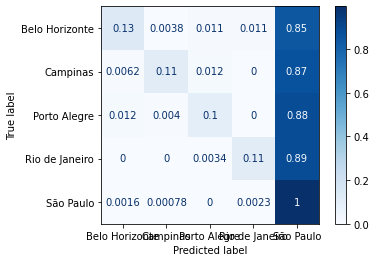

In [41]:
disp = ConfusionMatrixDisplay.from_estimator(clf, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

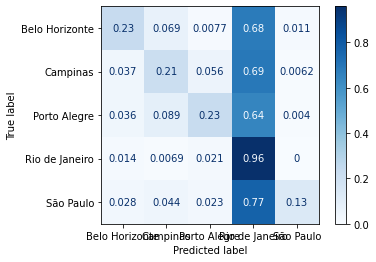

In [42]:
disp = ConfusionMatrixDisplay.from_estimator(clf_un, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

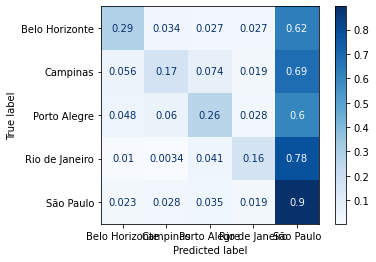

In [43]:
disp = ConfusionMatrixDisplay.from_estimator(clf_ov, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

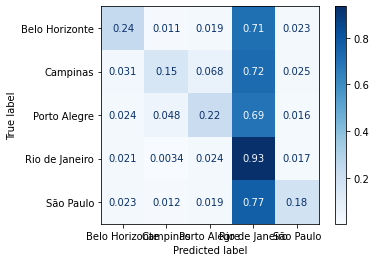

In [44]:
disp = ConfusionMatrixDisplay.from_estimator(clf_co, ZX, ZY,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

### Resumo

* desbalanceamento também pode ser um problema relevante em bases de dados reais
* ganhos significativos podem ser obtidos por meio de métodos de amostragem
